## Covid-19 Fake news Detection - LSTM

### Importing required library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Loading dataset and giving name to columns

In [2]:
df=pd.read_csv('covidnews.txt', sep="\t", header=None)
df.columns = ["label", "text"]

In [3]:
df.head()

,label,text
0,0,live launch of the access to covid tools act...
1,0,live one world togetherathome covid
2,1,dettol kills the coronavirus so it is not new
3,1,one thing for sure drink enough bleach and t...
4,1,isn t that horrible china has a patent on th...


In [4]:
# counting the number of missing values in the dataset
df.isnull().sum()

label    0
text     0
dtype: int64

In [5]:
## Get the Independent Features

X=df.drop('label',axis=1)

In [6]:
## Get the Dependent features
y=df['label']

In [7]:
X.shape

(22000, 1)

In [8]:
y.shape

(22000,)

In [9]:
### Vocabulary size
voc_size=5000

In [10]:
messages=X.copy()

In [11]:
messages['text'][1]

'  live one world togetherathome covid'

In [12]:
messages.reset_index(inplace=True)

### Preprocessing the data using NLP 

In [38]:
### Dataset Preprocessing

ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [39]:
#corpus

In [40]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
#onehot_repr

In [17]:
sent_length=30
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2661 3049 4109]
 [   0    0    0 ... 3981 3165 3139]
 [   0    0    0 ... 4479 3412 4350]
 ...
 [   0    0    0 ... 4414 3295 3139]
 [   0    0    0 ...   67  337  185]
 [   0    0    0 ...  997 3721 4298]]


In [18]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 4575, 4333, 1666, 3139, 2661, 3049, 4109])

### Defining Model-LSTM

In [19]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
len(embedded_docs),y.shape

(22000, (22000,))

In [21]:

X_final=np.array(embedded_docs)
y_final=np.array(y)

In [22]:
X_final.shape,y_final.shape

((22000, 30), (22000,))

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [24]:
### Finally Training
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
231/231 [==============================] - 21s 71ms/step - loss: 0.2188 - accuracy: 0.9065 - val_loss: 0.0957 - val_accuracy: 0.9691
Epoch 2/10
231/231 [==============================] - 19s 81ms/step - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.1008 - val_accuracy: 0.9665
Epoch 3/10
231/231 [==============================] - 19s 83ms/step - loss: 0.0448 - accuracy: 0.9874 - val_loss: 0.1066 - val_accuracy: 0.9656
Epoch 4/10
231/231 [==============================] - 19s 83ms/step - loss: 0.0324 - accuracy: 0.9921 - val_loss: 0.1385 - val_accuracy: 0.9638
Epoch 5/10
231/231 [==============================] - 19s 83ms/step - loss: 0.0306 - accuracy: 0.9915 - val_loss: 0.1426 - val_accuracy: 0.9618
Epoch 6/10
231/231 [==============================] - 19s 84ms/step - loss: 0.0230 - accuracy: 0.9942 - val_loss: 0.1500 - val_accuracy: 0.9585
Epoch 7/10
231/231 [==============================] - 20s 86ms/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 0.1839 - val_accuracy:

In [25]:
#y_pred=model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5)*1 

In [26]:
confusion_matrix(y_test,y_pred)

array([[3493,  171],
       [ 129, 3467]], dtype=int64)

In [27]:
accuracy_score(y_test,y_pred)

0.9586776859504132

In [28]:
print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9644    0.9533    0.9588      3664
           1     0.9530    0.9641    0.9585      3596

    accuracy                         0.9587      7260
   macro avg     0.9587    0.9587    0.9587      7260
weighted avg     0.9587    0.9587    0.9587      7260



### Plotting the history of Loss and Accuracy

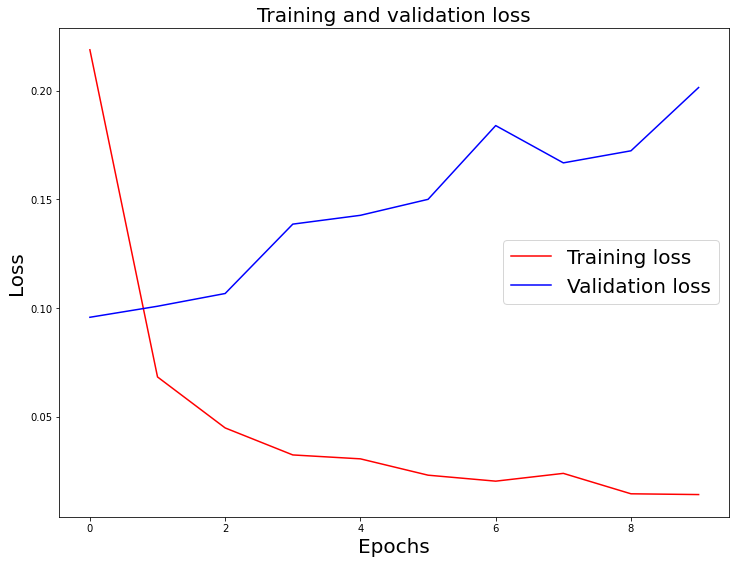

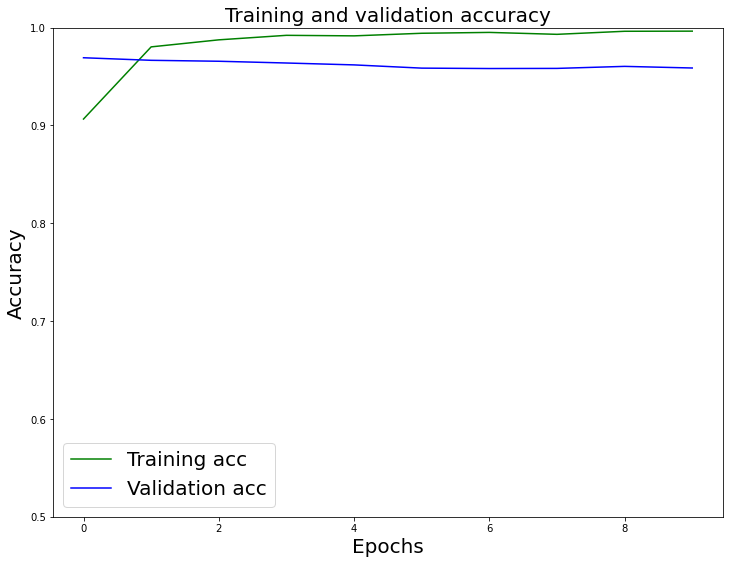

In [29]:

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [30]:
#from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 40)            200000    
                                                                 
 dropout_1 (Dropout)         (None, 30, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
231/231 [==============================] - 12s 42ms/step - loss: 0.2596 - accuracy: 0.8950 - val_loss: 0.1140 - val_accuracy: 0.9635
Epoch 2/10
231/231 [==============================] - 10s 43ms/step - loss: 0.0859 - accuracy: 0.9727 - val_loss: 0.0951 - val_accuracy: 0.9686
Epoch 3/10
231/231 [==============================] - 12s 52ms/step - loss: 0.0605 - accuracy: 0.9816 - val_loss: 0.0973 - val_accuracy: 0.9680
Epoch 4/10
231/231 [==============================] - 13s 56ms/step - loss: 0.0459 - accuracy: 0.9862 - val_loss: 0.1060 - val_accuracy: 0.9661
Epoch 5/10
231/231 [==============================] - 12s 53ms/step - loss: 0.0396 - accuracy: 0.9889 - val_loss: 0.1136 - val_accuracy: 0.9660
Epoch 6/10
231/231 [==============================] - 14s 59ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.1213 - val_accuracy: 0.9649
Epoch 7/10
231/231 [==============================] - 14s 60ms/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.1318 - val_accuracy:

In [33]:
#y_pred=model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5)*1 

In [34]:
confusion_matrix(y_test,y_pred)

array([[3461,  203],
       [  90, 3506]], dtype=int64)

In [35]:
accuracy_score(y_test,y_pred)

0.9596418732782369

In [36]:
print(classification_report(y_test,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9747    0.9446    0.9594      3664
           1     0.9453    0.9750    0.9599      3596

    accuracy                         0.9596      7260
   macro avg     0.9600    0.9598    0.9596      7260
weighted avg     0.9601    0.9596    0.9596      7260



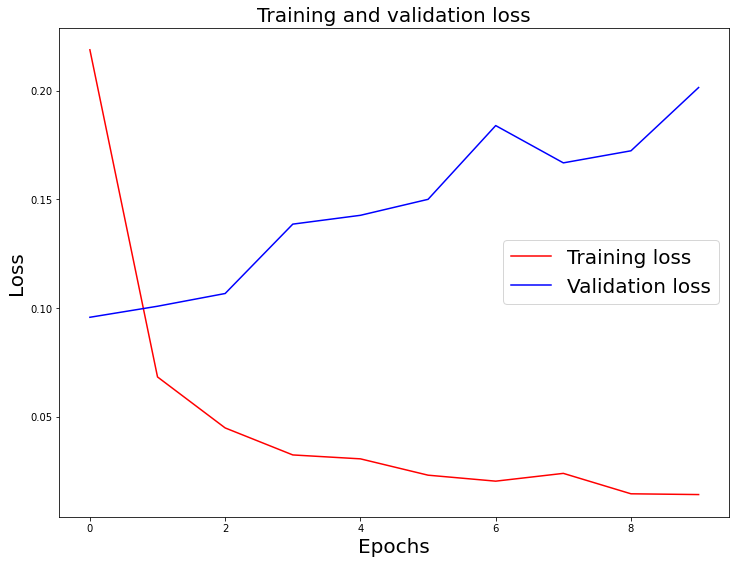

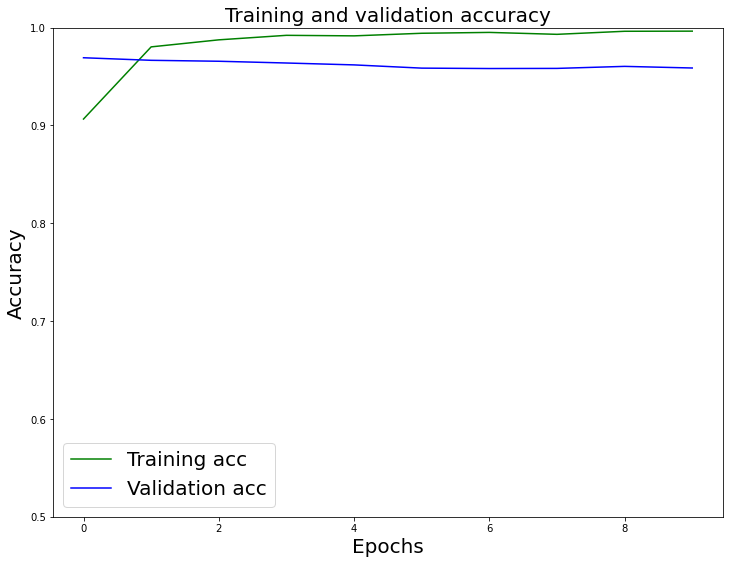

In [37]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()